# Modelling irregular bodies shape via ANNs
In this notebook we explore the possibility to use ANNs to represent the generic shape of an irregular body and be trained to reproduce a known gravitational potential field.

To get statically stable asteroids we use results from MPIA work by Francesco Biscani obtained during simulation of protoplanetary formation made by large n-body simulations. These data are included as a submodule in this git project.


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Loading and visualizing an asteroid as a point cloud

In [2]:
# We import the data from MPIA containing pseudo-stable asteroid shapes
f = h5py.File('sample_vis_data/sample_01/state_10567.hdf5','r')
f2 = h5py.File('sample_vis_data/sample_01/global.hdf5', 'r')

In [3]:
# The file state_ ... contains the positions of all particles as well as the indices
# of those belonging to a cluster. Here we extract the largest ones.
dims = [(len(f[cluster][()]), cluster) for cluster in f.keys() if 'cluster' in cluster]
largest_clusters = sorted(dims,reverse=True)

In [66]:
# We have ordered the largest asteroids, we now extract positions for one in particular
rank = 4
print("Target: ", largest_clusters[rank][1])
# The particles idxs for this cluster
idx = f[largest_clusters[rank][1]][()]
# The particle radius
radius = f2['radius'][()]
# Particle positions
x_raw = f['x'][()][idx]
y_raw = f['y'][()][idx]
z_raw = f['z'][()][idx]
print("Diameter: ", 2 * radius)

Target:  cluster_2400
Diameter:  0.00043088693800637674


In [67]:
from sklearn.neighbors import NearestNeighbors
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x_raw, np.append(y_raw,z_raw))
point_cloud = point_cloud.reshape((3,len(x_raw)))
point_cloud = np.transpose(point_cloud)

nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(point_cloud)
distances, indices = nbrs.kneighbors(point_cloud)

print("Minimum distance between particles: ", min(distances[:,1]))
print("Maximum distance between particles: ", max(distances[:,1]))

# We take out particles that are not "touching" at least two neighbours
unstable_points = np.where(distances[:, 3]> 2 * radius * 1.01)[0]
print("Number of unstable points: ", len(unstable_points))
x = np.delete(x_raw, unstable_points, 0)
y = np.delete(y_raw, unstable_points, 0)
z = np.delete(z_raw, unstable_points, 0)

Minimum distance between particles:  0.00042108838275198475
Maximum distance between particles:  0.0005132013991266676
Number of unstable points:  5


In [68]:
# We subtract the mean so that the origin is the center of figure
x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.mean(z)
# We normalize so that the z axis is at most one
x = x / max(abs(z))
y = y / max(abs(z))
z = z / max(abs(z))
radius = radius /  max(abs(z)) *1e5*6
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x, np.append(y,z))
point_cloud = point_cloud.reshape((3,len(x)))
point_cloud = np.transpose(point_cloud)

### Visualization via matplotlib

<IPython.core.display.Javascript object>


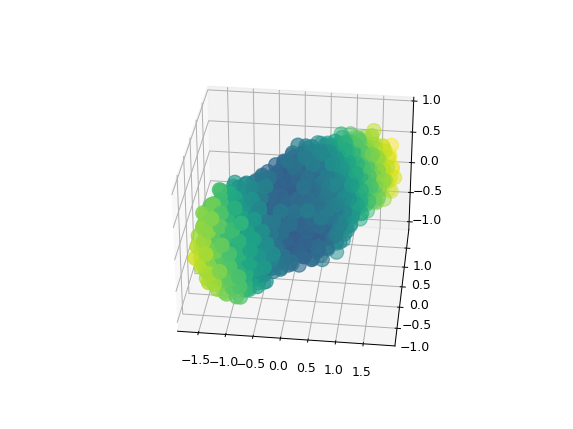

In [69]:
# We color the points w.r.t. their distance to the center
color = [np.linalg.norm([point]) for point in point_cloud] 
# And visualize the masses
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c = color, s = radius)


### Visualization via open3d

In [70]:
import numpy as np
import open3d as o3d

colors = np.exp(-np.array(color))
colors = np.append(np.append(colors, colors), colors).reshape((3, len(color))).transpose()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.colors = o3d.utility.Vector3dVector(colors)


hull, _ = pcd.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([pcd, hull_ls])

# Computing the gravitational potential of an asteroid (point cloud) in a point 
The Canvendish constant is not included (or $G=1$), so that we have:
$$
V = - \sum_{i=1}^N \frac{m_i}{|\mathbf x - \mathbf r_i|}
$$
where, assuming the asteroid with a unitary mass $m_i = 1/N$, hence:
$$
V = - \frac 1N \sum_{i=1}^N \frac{1}{|\mathbf x - \mathbf r_i|}
$$

In [81]:
def V(r, point_cloud):
    retval =0;
    for point in point_cloud:
        retval = retval + 1./np.linalg.norm(r-point)
    return - retval / len(point_cloud)

In [82]:
%timeit V(np.array([2,20,1]), point_cloud=point_cloud)

15.7 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Representing the asteroid via a neural network